**Rolling Window Sequence**

In [3]:
# 1. Imports and Data Loading
import pandas as pd
import numpy as np

# Load the feature-engineered dataset from previous step (adjust path as needed)
df = pd.read_csv('cmapss_feature_engineered_FD001.csv')  # Assume feature engineered file

# Basic info
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (20531, 68)


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_17_rollmean5,sensor_17_rollstd5,sensor_18_rollmean5,sensor_18_rollstd5,sensor_19_rollmean5,sensor_19_rollstd5,sensor_20_rollmean5,sensor_20_rollstd5,sensor_21_rollmean5,sensor_21_rollstd5
0,1,2,0.0019,-0.0003,100.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,...,-0.926028,-2.638069,0.0,0.0,0.0,0.0,1.367661,-1.534785,1.404213,-2.630752
1,1,3,-0.0043,0.0003,100.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,...,-1.453702,0.786588,0.0,0.0,0.0,0.0,1.192984,-1.166192,1.123794,-0.599129
2,1,4,0.0007,0.0000,100.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,...,-1.321784,0.327771,0.0,0.0,0.0,0.0,0.991014,-0.547098,1.064600,-0.923458
3,1,5,-0.0019,-0.0002,100.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,...,-1.084330,0.610846,0.0,0.0,0.0,0.0,0.896034,-0.625804,1.095643,-1.143645
4,1,6,-0.0043,-0.0001,100.0,0.0,-1.161771,-0.987297,-1.173703,-1.776357e-15,...,-1.242633,0.743509,0.0,0.0,0.0,0.0,0.791228,-1.279538,0.981948,-1.245030


In [4]:
# Columns to use as features (exclude id and cycle, plus target if any)
exclude_cols = ['engine_id', 'cycle']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Sort data by engine_id and cycle to ensure correct temporal order
df = df.sort_values(['engine_id', 'cycle']).reset_index(drop=True)

In [5]:
def generate_rolling_windows(data, engine_col, features, window_size=30):
    sequences = []
    engine_ids = []
    cycle_ids = []

    for engine in data[engine_col].unique():
        engine_data = data[data[engine_col] == engine]
        engine_features = engine_data[features].values

        # Generate sequences with rolling window
        for i in range(window_size - 1, len(engine_data)):
            seq = engine_features[i - window_size + 1 : i + 1]
            sequences.append(seq)
            engine_ids.append(engine)
            cycle_ids.append(engine_data.iloc[i]['cycle'])

    # Convert to array for modeling
    sequences = np.array(sequences)
    return sequences, engine_ids, cycle_ids

In [6]:
window_size = 30  # Typical rolling window length; adjust as needed
sequences, engine_ids, cycle_ids = generate_rolling_windows(df, 'engine_id', feature_cols, window_size)

print("Shape of rolling window sequences:", sequences.shape)  # (num_sequences, window_size, num_features)
print("Example sequence shape:", sequences[0].shape)

Shape of rolling window sequences: (17631, 30, 66)
Example sequence shape: (30, 66)


In [7]:
# Print the first sequence info
print(f"Engine ID: {engine_ids[0]}, Cycle: {cycle_ids[0]}")
print("Sequence data for first time window (shape {}):".format(sequences[0].shape))
print(sequences[0])

Engine ID: 1, Cycle: 31.0
Sequence data for first time window (shape (30, 66)):
[[ 1.90000000e-03 -3.00000000e-04  1.00000000e+02 ... -1.53478503e+00
   1.40421343e+00 -2.63075241e+00]
 [-4.30000000e-03  3.00000000e-04  1.00000000e+02 ... -1.16619245e+00
   1.12379400e+00 -5.99129117e-01]
 [ 7.00000000e-04  0.00000000e+00  1.00000000e+02 ... -5.47097938e-01
   1.06460040e+00 -9.23457744e-01]
 ...
 [ 1.20000000e-03 -1.00000000e-04  1.00000000e+02 ... -1.06697113e+00
   1.02930247e+00  4.59904157e-01]
 [-2.20000000e-03  0.00000000e+00  1.00000000e+02 ... -6.06104727e-01
   9.90458379e-01  3.42825323e-01]
 [ 1.40000000e-03  5.00000000e-04  1.00000000e+02 ... -1.31993488e+00
   8.16751090e-01  3.47734290e-01]]


In [8]:
# Check that sequence length matches window size
assert sequences.shape[1] == window_size, "Sequence window length mismatch"

# Check that sequences are ordered by cycle (manual inspection example)
assert all(cycle_ids[i] > cycle_ids[i-1] or engine_ids[i] != engine_ids[i-1] for i in range(1, len(cycle_ids))), "Cycle order violation"

print("Basic validation checks passed.")

Basic validation checks passed.


In [9]:
# Save sequences and metadata for modeling
np.save('rolling_window_sequences.npy', sequences)
pd.DataFrame({'engine_id': engine_ids, 'cycle': cycle_ids}).to_csv('sequence_metadata.csv', index=False)

**Model_training**

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [28]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 66)
y shape: (17631,)


In [29]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


In [30]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [31]:
# LSTM Model for RUL Prediction
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Training Setup: Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

In [33]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/50
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7524.5132
Epoch 1: val_loss improved from inf to 5808.55762, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 7512.3311 - val_loss: 5808.5576 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5407.8799
Epoch 2: val_loss improved from 5808.55762 to 4513.83838, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 5406.5439 - val_loss: 4513.8384 - learning_rate: 0.0010
Epoch 3/50
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4189.5840
Epoch 3: val_loss improved from 4513.83838 to 3483.70605, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 4185.3384 - val_loss: 3483.7061 - learning_rate: 0.0010
Epoch 4/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3240.4170
Epoch 4: val_loss improved from 3483.70605 to 2705.44312, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━

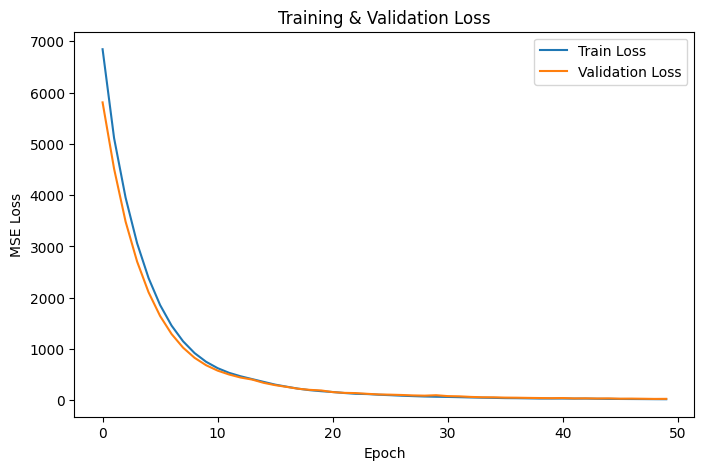

In [34]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


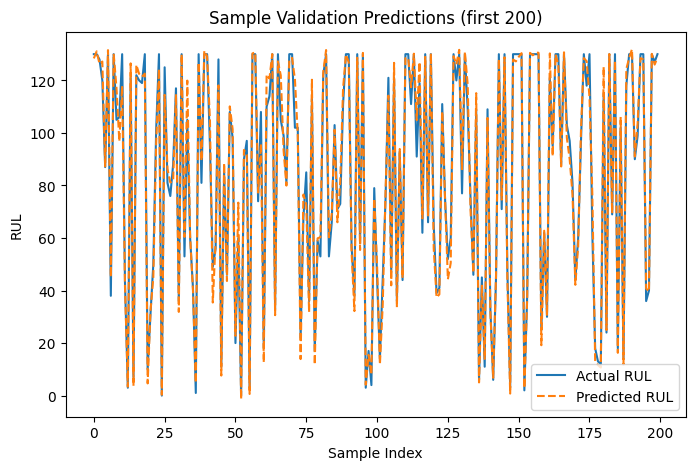

In [35]:
# Verify Model Predictions
val_pred = model.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

**Quantitative Metrics for Model Evaluation**

**Imports and Setup**

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt

# Suppress warnings for clearer output
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Assuming test data (X_test, y_test) and trained model saved as "best_lstm_model.keras"
# Load test features and labels
X_test = np.load("rolling_window_sequences.npy")  # Replace with actual file path
metadata_test = pd.read_csv("sequence_metadata_with_RUL.csv")  # Replace with actual file path
y_test = metadata_test["RUL"].values

print("Test feature shape:", X_test.shape)
print("Test target shape:", y_test.shape)

# Load trained LSTM model
model = tf.keras.models.load_model("best_lstm_model.keras")

Test feature shape: (17631, 30, 66)
Test target shape: (17631,)


In [41]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()  # Flatten to 1-D array for metric calculations

print("Predictions shape:", y_pred.shape)

551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Predictions shape: (17631,)


In [42]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Root Mean Squared Error (RMSE): 4.5924
Mean Absolute Error (MAE): 3.2543


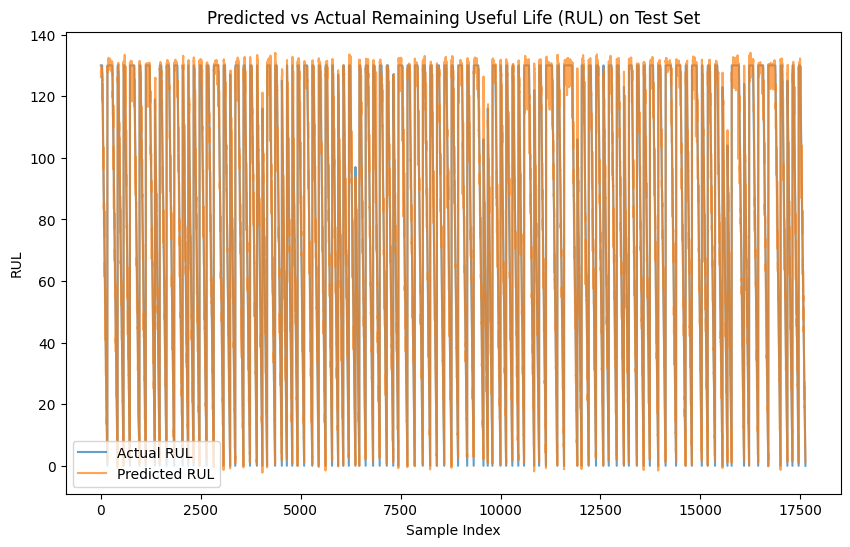

In [43]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual RUL', alpha=0.7)
plt.plot(y_pred, label='Predicted RUL', alpha=0.7)
plt.title('Predicted vs Actual Remaining Useful Life (RUL) on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()